This document is the execution of the matchms tutorial at https://blog.esciencecenter.nl/build-your-own-mass-spectrometry-analysis-pipeline-in-python-using-matchms-part-i-d96c718c68ee

**IMPORT MS/MS DATA**

matchms can import MS/MS data from several common file formats such as .mzml, .mzxml, or GNPS-style .mgf files. Another option would be to use the Universal Spectrum Identifier for mass spectra.
Let’s start with some spectra that we download from GNPS in form of a .mgf file from this GNPS website (https://gnps-external.ucsd.edu/gnpslibrary). Use this file https://gnps-external.ucsd.edu/gnpslibrary/GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf

In [1]:
import os
import numpy as np
from matchms.importing import load_from_mgf

In [2]:
path_data = "/mnt/scratch/rebac002/spec2vec-mass-spectral-embeddings-visualization/matchms_tutorial" #enter path to download mgf file
file_mgf = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf")
spectrums = list(load_from_mgf(file_mgf))

Now you will have spectrums which is a Python list full of matchms-type Spectrum objects. When running **len(spectrums)** you can see that we have just imported 1267 mass spectra.

In [3]:
len(spectrums)

1267

Each of those objects contains the spectrum metadata (**spectrum.metadata**) and the spectrum peaks (**spectrum.peaks** with **spectrum.peaks.mz** and **spectrum.peaks.intensities**). Say, you want to access the metadata of a particular spectrum in your list (for example the 5th spectrum). Then you can either call **spectrums[4].metadata** which will return a dictionary of all metadata information, or you can call **spectrums[4].get("smiles")** to only get the specific metadata entry for that particular spectrum.

In [4]:
spectrums[4].metadata

{'pepmass': (481.245, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-qTof',
 'filename': 'p1-A05_GA5_01_17878.mzXML',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-NIH-NATURALPRODUCTSLIBRARY',
 'name': '"MLS001158449-01!(2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan-2-yl-2,4-dihydroquinoxaline-1-carbonyl]amino]butanoyl]amino]-3-phenylpropanoic acid" M+H',
 'pi': 'Dorrestein',
 'datacollector': 'VVP/LMS',
 'smiles': 'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'inchi': 'N/A',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'vphelan',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00000079354',
 'scans': '2030'}

In [5]:
spectrums[4].get("smiles")

'CC(C)[C@H](NC(=O)N1[C@@H](C(C)C)C(=O)Nc2ccccc12)C(=O)N[C@@H](Cc3ccccc3)C(=O)O'

**INSPECT THE DATA**

Let’s inspect the data that we just imported a bit more. For instance by having a closer look at some key metadata entries such as smiles, InChIKey and InChIs. Here a bit of code to have a closer look at the InChIKey entries in the imported data:

In [6]:
inchikeys = [s.get("inchikey") for s in spectrums]
found_inchikeys = np.sum([1 for x in inchikeys if x is not None])
print(f"Found {int(found_inchikeys)} inchikeys in metadata")

Found 0 inchikeys in metadata


This will show that the metadata for the imported spectra do not contain InChIKey entries (no entries at all or no entries in the expected fields).
We can also inspect the data by plotting a histogram of how many peaks the spectra have.

Text(0, 0.5, 'Number of spectra')

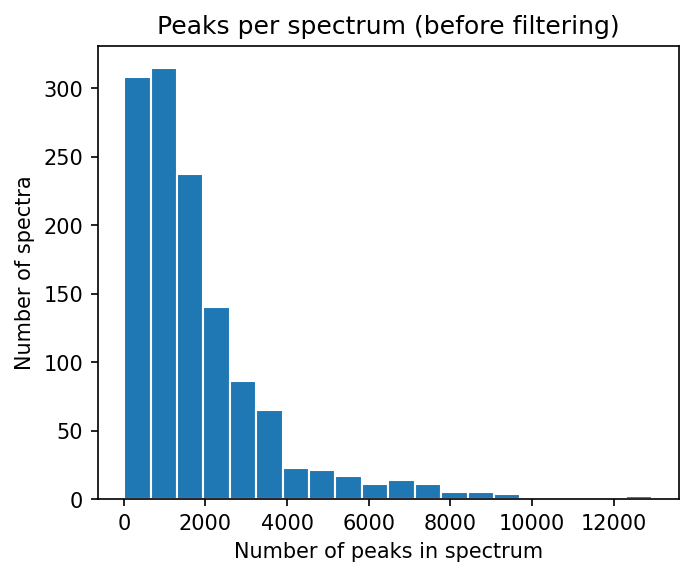

In [7]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

This reveals that most spectra here contain a lot of peaks (figure 1), most of which we expect to be low intensity noise peaks. In a next step we will further process the data and remove peaks below a set intensity threshold which will also drastically reduce the number of peaks per spectrum (see figure 2, right side).

**EXPORT PROCESSED DATA**

There are multiple options to export your data after processing. Using **save_as_json** or **save_as_mgf** the data can be written back to a .json or .mgf file.

In [8]:
from matchms.exporting import save_as_json

file_export_json = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.json")
save_as_json(spectrums, file_export_json)

A alternative that is much faster for reading/writing is to use **pickle**. Should data handling become an issue (e.g. many thousands spectrums), than this can be a way out.

In [9]:
import pickle

file_export_pickle = os.path.join(path_data, "GNPS-NIH-NATURALPRODUCTSLIBRARY_processed.pickle")
pickle.dump(spectrums, open(file_export_pickle, "wb"))

**BUILD A DATA PROCESSING PIPELINE**

Depending on the data that you import, in most cases you might want to further process the spectra. matchms offers numerous ‘filters’ to process Spectrum objects. They are designed in a way that allows to simply stack them to any processing pipeline you want. In general, **matchms.filtering** contains filters that either will:
    -harmonize, clean, extend, and/or check the spectrum metadata
    -process or filter spectrum peaks (e.g. remove low intensity peaks, or normalize peak intensities)

Since all those filtering functions will input but also output a Spectrum you can also easily write your own filtering function in Python and add it to your pipeline. Above we have seen that the imported spectra lack at least part of the metadata that we would expect and in addition they seem to contain a lot of peaks (suggesting that there are many noise peaks that could be removed). A typical preprocessing pipeline could consist of two parts, one to clean up the metadata and one to further process the peaks. The first part could look like this:

In [10]:
from matchms.filtering import default_filters
from matchms.filtering import repair_inchi_inchikey_smiles
from matchms.filtering import derive_inchikey_from_inchi
from matchms.filtering import derive_smiles_from_inchi
from matchms.filtering import derive_inchi_from_smiles
from matchms.filtering import harmonize_undefined_inchi
from matchms.filtering import harmonize_undefined_inchikey
from matchms.filtering import harmonize_undefined_smiles

def metadata_processing(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = repair_inchi_inchikey_smiles(spectrum)
    spectrum = derive_inchi_from_smiles(spectrum)
    spectrum = derive_smiles_from_inchi(spectrum)
    spectrum = derive_inchikey_from_inchi(spectrum)
    spectrum = harmonize_undefined_smiles(spectrum)
    spectrum = harmonize_undefined_inchi(spectrum)
    spectrum = harmonize_undefined_inchikey(spectrum)
    return spectrum

Here we defined a sequence of filters to be applied to a spectrum, which will apply **default filters** (a bunch of standard operations to make metadata entries more consistent). Then we run a number of filters that look for inchi, inchikey, and smiles that ended up in wrong fields (**repair_inchi_inchikey_smiles**), and ultimately translate inchi, inchikey, and smiles into another wherever possible.

To process the peaks we define another pipeline:

In [11]:
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_intensity
from matchms.filtering import select_by_mz

def peak_processing(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_intensity(spectrum, intensity_from=0.01)
    spectrum = select_by_mz(spectrum, mz_from=10, mz_to=1000)
    return spectrum

Here we defined a sequence of filters which will normalize the intensities to values between 0 and 1, and finally only keep peaks if they have a normalized intensity > 0.01 and if they have a m/z position between 10 and 1000 Da.

Once defined in this way, we can easily apply this processing sequence to all imported spectrums by doing:

In [12]:
spectrums = [metadata_processing(s) for s in spectrums]
spectrums = [peak_processing(s) for s in spectrums]

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2R)-2-[3-[(10aS)-1,3-dioxo-10,10a-dihydro-5H-imidazo[1,5-b]isoquinolin-2-yl]propanoylamino]-2-phenylacetic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-3-benzoyl-2,7b-dihydro-1aH-oxireno[2,3-c]quinoline-2-carbonitrile"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 5-hydroxy-7-methoxy-2-phenylchromen-4-one
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-[2-[7-methoxy-6-[(Z)-(2,4,6-trioxo-1-prop-2-enyl-1,3-diazinan-5-ylidene)methyl]-1,3-benzodioxol-5-yl]ethyl]-N-methylbenzamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-2-[[(2S)-3-methyl-2-[[(2S)-3-oxo-2-propan-2-yl-2,4-dihydroquinoxaline-1-carbonyl]amino]butanoyl]amino]-3-phenylpropanoic acid"
Remove

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-2-[[2-(3-benzyl-4-methyl-2-oxochromen-7-yl)oxyacetyl]amino]-3-phenylpropanoic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-2-[[2-(3-hexyl-4-methyl-2-oxochromen-7-yl)oxyacetyl]amino]-3-phenylpropanoic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2R)-2-[[(2R)-2-[[1-[(2-methylpropan-2-yl)oxycarbonyl]-4-phenylpiperidine-4-carbonyl]amino]propanoyl]amino]-2-phenylacetic acid
Removed adduct M+Na from compound name.
Added adduct [M+Na]+ to metadata.
Added cleaned compound name: (2R)-2-[[(2R)-2-[[1-[(2-methylpropan-2-yl)oxycarbonyl]-4-phenylpiperidine-4-carbonyl]amino]propanoyl]amino]-2-phenylacetic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(4-butyl-2-oxochromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-2-[2-[(6-oxo-7,8,9,10-tetrahydrobenzo[c]chromen-3-yl)oxy]propanoylamino]-2-phenylacetic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-3-(1H-indol-3-yl)-2-[[(2S)-4-methyl-2-[(3-oxo-2,4-dihydroquinoxaline-1-carbonyl)amino]pentanoyl]amino]propanoic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-[2-(5-methoxy-1H-indol-3-yl)ethyl]-2-(2-oxo-4-propylchromen-7-yl)oxyacetamide
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2-(1,3-benzodioxol-5-yl)-1-methylquinolin-4-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-1-[(2S)-5-amino-2-[[(2S)-2-(2,4-dioxo-1H-quinazolin-3-yl)-3-phenylpropanoyl]amino]-5-oxopentanoyl]pyrrolidine-2-carboxylic acid"
Remove

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: methyl 1-[1-[(2S)-3-methyl-2-[(4-methylphenyl)sulfonylamino]pentanoyl]piperidine-4-carbonyl]piperidine-4-carboxylate
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (3S,5R,8R,9S,10S,13S,14S)-3-hydroxy-10,13-dimethyl-1,2,3,4,5,6,7,8,9,11,12,14,15,16-tetradecahydrocyclopenta[a]phenanthren-17-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (E)-1-[3-(2-hydroperoxy-3-methylbut-3-enyl)-2-hydroxy-4-methoxyphenyl]-3-(4-hydroxyphenyl)prop-2-en-1-one
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (4S,4aS,5aS,6S,12aR)-7-chloro-4-(dimethylamino)-1,6,10,11,12a-pentahydroxy-6-methyl-3,12-dioxo-4,4a,5,5a-tetrahydrotetracene-2-carboxamide"


Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-1-[2-[(4-oxo-2,3-dihydro-1H-cyclopenta[c]chromen-7-yl)oxy]acetyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 6-methoxy-2-(4-methoxyphenyl)chromen-4-one
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Add

RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:31] WARNING: Omitt

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+2H from compound name.
Added adduct [M+2H]2+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 5,7-dihydroxy-2-(4-hydroxyphenyl)-6-(3-methylbut-2-enyl)-2,3-dihydrochromen-4-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 5,7-dihydroxy-2-(4-hydroxy-3-methoxyphenyl)chromen-4-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 3,8-dimethyl-3-(4-methylpent-3-enyl)-11H-py

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-[(3-methoxyphenyl)methyl]-2-[(4,8,8-trimethyl-2-oxo-9,10-dihydropyrano[2,3-h]chromen-5-yl)oxy]acetamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 7-methoxy-1-methyl-2,3,4,9-tetrahydro-1H-pyrido[3,4-b]indole"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2R)-2-[[(2S)-2-(1,2-dihydroimidazo[1,2-a]benzimidazole-3-carbonylamino)-4-methylsulfanylbutanoyl]amino]-2-phenylacetic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (E)-1-(2,3-dihydroxy-4,6-dimethoxyphenyl)-3-phenylprop-2-en-1-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 3-(3,5-dimethyl-7-oxofuro[3,2-g]chromen-6-yl)-N-(pyridin-2-ylmethyl)propanamide"
Removed adduct M+H from compound name.
Added adduct 

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 1-[2-(4,8-dimethyl-2-oxochromen-7-yl)oxyacetyl]piperidine-4-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-1-[2-[[(2Z)-2-[(3,4-dimethoxyphenyl)methylidene]-3-oxo-1-benzofuran-6-yl]oxy]acetyl]-4-hydroxypyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 3-(4-chlorophenyl)-2-[[2-(8-methyl-2-oxo-4-phenylchromen-7-yl)oxyacetyl]amino]propanoic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-cyclopropyl-3-(7-methoxy-4,8-dimethyl-2-oxochromen-3-yl)propanamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2-[[2-(6-chloro-2-oxo-

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(4-butyl-7-methyl-2-oxochromen-5-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(2-oxo-4-propylchromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(6-ethyl-2-oxo-4-phenylchromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2-[[2-(3-benzyl-4-methyl-2-oxochromen-7-yl)oxyacetyl]amino]-3-(4-chlorophenyl)propanoic acid
Removed adduct M+H 

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-1-[(2S)-2-[[(2S)-2-(2,4-dioxo-1H-quinazolin-3-yl)-3-phenylpropanoyl]amino]propanoyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-(2,3-dihydroxy-3-methylbutoxy)furo[3,2-g]chromen-7-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2-methoxyphenazine
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compou

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(6-chloro-2-oxo-4-phenylchromen-7-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2R)-2-[6-(1,2-dihydroimidazo[1,2-a]benzimidazole-3-carbonylamino)hexanoylamino]-3-phenylpropanoic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: methyl 2-benzamidoacetate
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 5-hydroxy-2,2-dimethyl-7-[2-oxo-2-(4-phenylpiperazin-1-yl)ethoxy]-3H-chromen-4-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2,3-dimethoxyxanthen-9-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-3-(1H-indol-3-yl)-2-[2-(3,4,8-trimethyl-2-oxochro

RDKit WARNING: [14:54:32] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitted undefined stereo
RDKit WARNING: [14:54:33] WARNING: Omitt

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[[2-(8-methoxy-6-oxobenzo[c]chromen-3-yl)oxyacetyl]amino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2R)-1-[2-(4-ethyl-8-methyl-2-oxochromen-7-yl)oxypropanoyl]pyrrolidine-2-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-[2-[7-methoxy-6-[(2,4,6-trioxo-1,3-diazinan-5-ylidene)methyl]-1,3-benzodioxol-5-yl]ethyl]-N-methylbenzamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 1-[2,4-dihydroxy-6-methoxy-3-(3-methylbut-2-enyl)phenyl]-3-(4-hydroxyphenyl)propan-1-one"
Remov

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-N-(2-ethylphenyl)-5-oxo-1-(3-oxo-1H-2-benzofuran-1-yl)pyrrolidine-2-carboxamide
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (3S)-N-[(2S)-1-[(4-methoxyphenyl)methylamino]-3-methyl-1-oxopentan-2-yl]-1,2,3,4-tetrahydroisoquinoline-3-carboxamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-(3-imidazol-1-ylpropyl)-3-(2,3,5-trimethyl-7-oxofuro[3,2-g]chromen-6-yl)propanamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 5,7-dihydroxy-2-[4-methoxy-3,5-bis(3-methylbut-2-enyl)phenyl]-2,3-dihydrochromen-4-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduc

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-1-[(2S)-2-[(4,6-dimethoxy-1-methylindole-2-carbonyl)amino]-3-methylbutanoyl]pyrrolidine-2-carboxylic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-N-(5-chloro-2,4-dimethoxyphenyl)-1-(4,5-dimethoxy-3-oxo-1H-2-benzofuran-1-yl)-5-oxopyrrolidine-2-carboxamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S,3S,3aR)-2-(1,3-benzodioxol-5-yl)-5,7-dimethoxy-3-methyl-3a-prop-2-enyl-2,3-dihydro-1-benzofuran-6-one"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[2-(2-oxo-4-propylchromen-7-yl)oxypropanoylamino]methyl

Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: N-(3-morpholin-4-ylpropyl)-3-(2,3,5-trimethyl-7-oxofuro[3,2-g]chromen-6-yl)propanamide"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 2-[4-(4-methoxyphenyl)-8-methyl-2-oxochromen-7-yl]oxy-N-(pyridin-2-ylmethyl)propanamide
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 4-[[2-(6-chloro-2-oxo-4-propylchromen-7-yl)oxypropanoylamino]methyl]cyclohexane-1-carboxylic acid
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: (2S)-2-[2-[(6-methyl-4-oxo-2,3-dihydro-1H-cyclopenta[c]chromen-7-yl)oxy]propanoylamino]-3-phenylpropanoic acid"
Removed adduct M+H from compound name.
Added adduct [M+H]+ to metadata.
Added cleaned compound name: 1-[(2S)-2-amino-4-methylsulfanylbutanoyl]-N-[(2R)-1-oxo-1-(1-phenylethylamino)propan-2-yl]piperidine-4-carbox

Now, let’s inspect the number of peaks per spectrum again. As you can see, the filtering (mostly the removal of peaks below 0.01 max intensity) has drastically reduced the number of peaks per spectrum (compare to first plot).

Text(0, 0.5, 'Number of spectra')

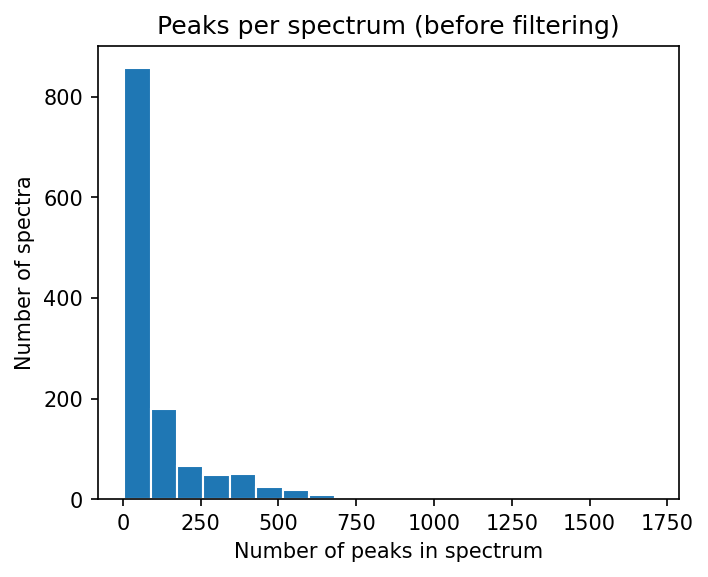

In [13]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectrums]

from matplotlib import pyplot as plt
plt.figure(figsize=(5,4), dpi=150)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (before filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")

Also the metadata was improved a lot and we now find inchikeys as we would expect. We can for instance run:

In [14]:
inchikeys = [s.get("inchikey") for s in spectrums]
inchikeys[:10]

['XTJNPXYDTGJZSA-PKOBYXMFSA-N',
 'VOYWJNWCKFCMPN-FHERZECASA-N',
 'IRZVHDLBAYNPCT-UHFFFAOYSA-N',
 'OPWCHZIQXUKNMP-RGEXLXHISA-N',
 'GTBYYVAKXYVRHX-BVSLBCMMSA-N',
 'UVZWLAGDMMCHPD-UHFFFAOYSA-N',
 'XKWILXCQJFNUJH-DEOSSOPVSA-N',
 'JDZNIWUNOASRIK-UHFFFAOYSA-N',
 'RCAVVTTVAJETSK-VXKWHMMOSA-N',
 'KQAZJQXFNDOORW-CABCVRRESA-N']

**COMPUTE SPECTRA SIMILARITIES: COSINE SCORE**

We want to compare all spectra with each other to find out which ones are similar to each other. For this we will first have to chose a similarity score type and set the parameters the way we want. We’ll start with the ‘Cosine score’ which multiplies matching peaks and is meant to find (nearly-) identical spectra. Importing the function and setting the parameter(s) goes like this:

In [15]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

similarity_measure = CosineGreedy(tolerance=0.005)

Then, we can do the computation to the Cosine scores for all possible spectrum pairs (1267 x 1267 pairs). Since the similarity scores for pair_i_j is the same as pair_j_i, we set **is_symmetric=True** to speed up calculations a bit. Still, the next step means calculating about 800,000 cosine scores which might take a bit (few to a few dozens of minutes):

In [16]:
scores = calculate_scores(spectrums, spectrums, similarity_measure, is_symmetric=True)

As a result, we get a **Scores** object which contains the spectra and all scores. The actual scores are stored in **scores.scores** and since we use the Cosine score this will contain both the Cosine similarity score and the number of matches. Let’s inspect some of the number of matching peaks by:

In [17]:
scores.scores[:5, :5]["matches"]

array([[40,  2,  1,  4,  1],
       [ 2, 75,  2,  5,  1],
       [ 1,  2, 37,  4,  0],
       [ 4,  5,  4, 66,  0],
       [ 1,  1,  0,  0, 43]])

or access the corresponding Cosine scores by running:

In [18]:
scores.scores[:5, :5]["score"]

array([[1.00000000e+00, 6.41050958e-03, 1.70386100e-04, 8.59172648e-04,
        2.35757313e-03],
       [6.41050958e-03, 1.00000000e+00, 1.37105333e-02, 9.45693252e-01,
        9.17922823e-05],
       [1.70386100e-04, 1.37105333e-02, 1.00000000e+00, 1.53604286e-02,
        0.00000000e+00],
       [8.59172648e-04, 9.45693252e-01, 1.53604286e-02, 1.00000000e+00,
        0.00000000e+00],
       [2.35757313e-03, 9.17922823e-05, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00]])

**GET MOST SIMILAR SPECTRA FOR SPECTRUM OF INTEREST**

If we want to see which spectra are most similar to the i-th spectrum (according to the here used Cosine score), then we can call:

In [19]:
best_matches = scores.scores_by_query(spectrums[5], sort=True)[:10]
print([x[1] for x in best_matches])

#returns the scores for the top-10 candidates (Cosine score + number of matching peaks)

[(1., 30), (0.99711049, 2), (0.99534901, 2), (0.99214557, 2), (0.98748381, 2), (0.98461111, 3), (0.98401833, 2), (0.97598497, 2), (0.9757458, 2), (0.97547771, 2)]


The first, highest ranked results is the spectrum itself, but what are those other candidates, all with pretty high Cosine scores? Let’s find out by looking at the respective smiles (smiles are notations for the chemical structure of the compounds):

In [20]:
[x[0].get("smiles") for x in best_matches]

['OC(COC(=O)c1ccccc1)C(O)C(O)COC(=O)c2ccccc2',
 'Cc1cc(=O)oc2cc(OC(=O)c3ccccc3)ccc12',
 'O=C(Nc1ccccc1OC(=O)c2ccccc2)c3ccccc3',
 'COc1cc(CC=C)ccc1OC(=O)c2ccccc2',
 'O=C(OCC1OC(C(OC(=O)c2ccccc2)C1OC(=O)c3ccccc3)n4ncc(=O)[nH]c4=O)c5ccccc5',
 'O=C(Oc1cccc2ccccc12)c3ccccc3',
 'O=C(N1[C@@H](C#N)C2OC2c3ccccc13)c4ccccc4',
 'COC(=O)CNC(=O)c1ccccc1',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1C=C4C(=O)NC(=O)NC4=O',
 'COc1c2OCOc2cc(CCN(C)C(=O)c3ccccc3)c1/C=C\\4/C(=O)NC(=O)N(C)C4=O']

For those who are not used to reading smiles all the time (like me), let’s display the structures. There are many online and offline tools for plotting structures from smiles. Here, I used the Python package rdkit for it by running:

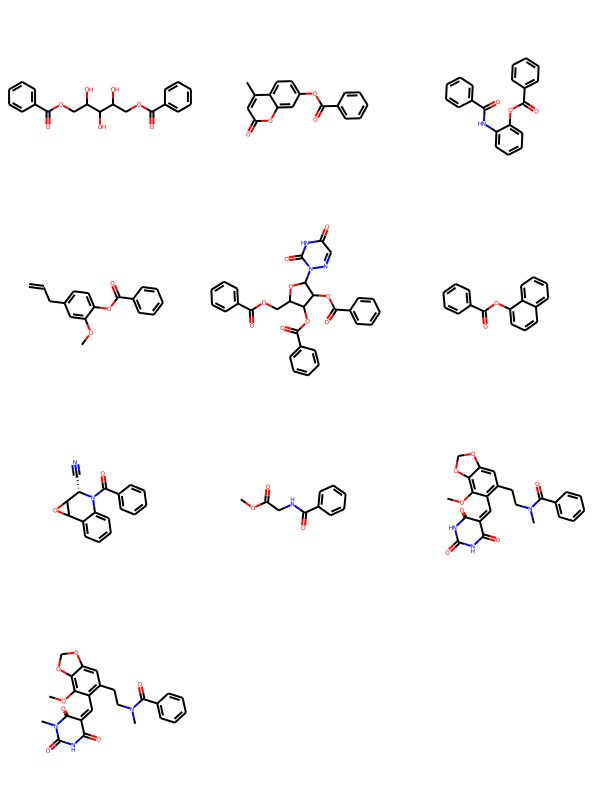

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw

ms = [] #make empty list
for i, smiles in enumerate([x[0].get("smiles") for x in    best_matches]):
    m = Chem.MolFromSmiles(smiles)
    ms.append(m) #append all m's to the list 'ms'
    #Draw.MolToFile(m, f"compound_{i}.png") #write to file
    
Chem.Draw.MolsToGridImage(ms) #draws all m's from the list 'ms'
    
#http://rdkit.org/docs/source/rdkit.Chem.Draw.html

**ALTERNATIVE: GET BEST MAATCHES ABOVE 'min_match' THRESHOLD**

Maybe having two matching peaks is not good enough and you want to be more certain of your Cosine score based candidates. Let’s then only consider the best Cosine scores for which we have at least min_match matches:

In [22]:
min_match = 5
sorted_matches = scores.scores_by_query(spectrums[5], sort=True)
best_matches = [x for x in sorted_matches if x[1]["matches"] >= min_match][:10]

[x[1] for x in best_matches]

[(1., 30),
 (0.44857215, 6),
 (0.39605775, 5),
 (0.33880658, 5),
 (0.03942863, 6),
 (0.03429136, 5),
 (0.03028157, 5),
 (0.02845932, 5),
 (0.01924283, 7),
 (0.01890612, 5)]

which will give a very different result than the previous run. Here we do not find any other spectrum in the dataset that shows a very high Cosine score (again, except the first entry which is the similarity of the spectrum with itself and hence obviously = 1):

**COMPUTE SPECTRA SIMILARITIES: MODIFIED COSINE SCORE**

The modified cosine score aims at quantifying the similarity between two mass spectra. Unlike the Cosine score it does not only look at nearly identical spectra, but also considers the mass shift between two compounds. The score is calculated by finding best possible matches between peaks of two spectra. Two peaks are considered a potential match if their m/z ratios lie within the given ‘tolerance’, or if their m/z ratios lie within the tolerance once a mass-shift is applied. The mass shift is simply the difference in precursor-m/z between the two spectra. See Watrous et al. (PNAS, 2012) for further details.

As done above for the Cosine score, we can calculate the similarities for all possible spectrum pairs by running:

In [23]:
from matchms.similarity import ModifiedCosine

similarity_measure = ModifiedCosine(tolerance=0.005)
scores = calculate_scores(spectrums, spectrums, similarity_measure,
                          is_symmetric=True)

Let’s then visualize the results for the first 50 x 50 spectrum pairs.

Text(0, 0.5, 'Spectrum #ID')

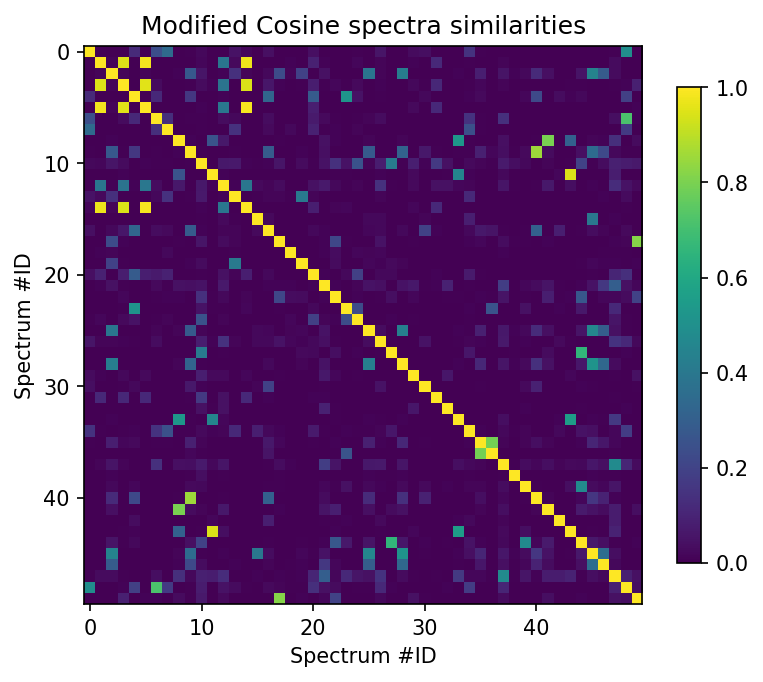

In [24]:
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores.scores[:50, :50]["score"], cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Modified Cosine spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")

Now, let’s accept Modified Cosine scores for a minimum number of matching peaks (min_match).

Text(0, 0.5, 'Spectrum #ID')

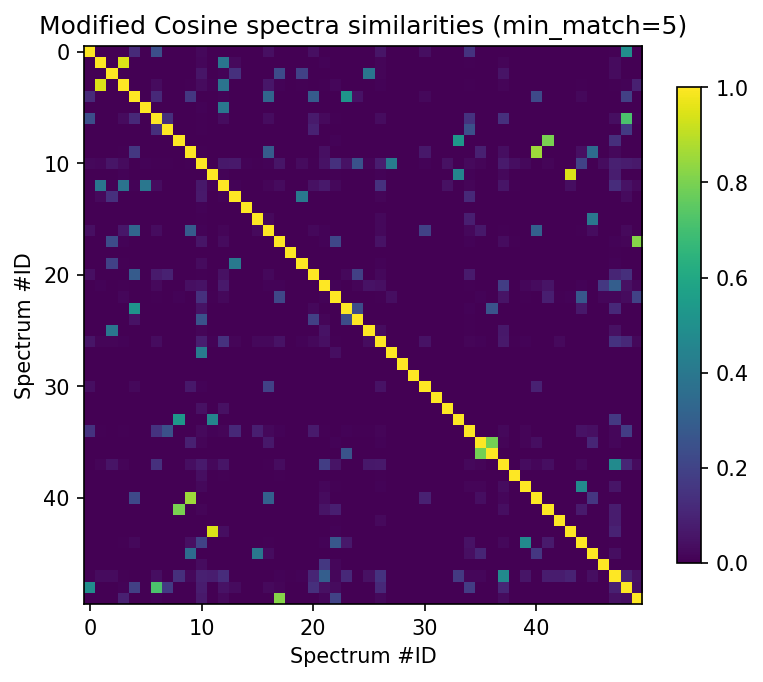

In [25]:
min_match = 5

plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores.scores[:50, :50]["score"] * (scores.scores[:50,
    :50]["matches"] >= min_match), cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Modified Cosine spectra similarities (min_match=5)")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")

There’s for instance a bright spot far outside the diagonal for spectrums[11] so let’s have a look at that one!

In [26]:
min_match = 5

sorted_matches = scores.scores_by_query(spectrums[11], sort=True)
best_matches = [x for x in sorted_matches if x[1]["matches"] >= min_match][:10]
[x[1] for x in best_matches]

[(1., 151),
 (0.95295779, 15),
 (0.94542762, 13),
 (0.89735889, 17),
 (0.7886489, 12),
 (0.77433041, 9),
 (0.74935776, 8),
 (0.72854032, 8),
 (0.55896333, 7),
 (0.52331993, 9)]

And, probably more interesting, the corresponding smiles:

In [27]:
[x[0].get("smiles") for x in best_matches]

['CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CC(=O)O)C(=O)O',
 'CCCCCC(NC(=O)C1CCN(CC1)C(=O)[C@@H](NS(=O)(=O)c2ccc(C)cc2)C(C)C)C(=O)O',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](CCC(=O)N)C(=O)O',
 'COC(=O)C1CCN(CC1)C(=O)C2CCN(CC2)C(=O)[C@@H](NS(=O)(=O)c3ccc(C)cc3)C(C)C',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@H](C(=O)O)c3ccccc3',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](C(C)C)C(=O)O',
 'CC(C)C[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N[C@@H](Cc3ccccc3)C(=O)O',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)N',
 'CCC(C)[C@H](NS(=O)(=O)c1ccc(C)cc1)C(=O)N2CCC(CC2)C(=O)N3CCC(CC3)C(=O)OC']